## Funções

In [1]:
import pandas as pd
import numpy as np
# from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as date
from scipy import stats
import time
import sklearn
import seaborn as sns
import talib as ta
import graphviz
pd.options.mode.chained_assignment = None
from matplotlib import style
style.use('dark_background')

def base_dados(ativo_name):
    #Data
    ativo = yf.download(ativo_name,start='2002-01-01',end='2022-01-01') 
    df = ativo
    df = df[['Close','High','Low','Open']]

    #Alvo: Retorno de t+1
    df['Retorno'] = df['Close'].pct_change()
    df['Alvo1'] = df['Retorno'].shift(-1)
    df['Alvo_bin'] = np.where(df['Alvo1'] > 0,1,0)
    df = df.dropna()
    #Train_test_Split
    #Insight = fazer pd.cut com variaveis continuas.
    return df

#df_cambio = index = data, coluna = ['cambio']

def add_var(df,df_var):
    if df_var.columns in list(df.columns):
        print(f'{df_var.columns[0]} ja foi acrescentada, no df')
    else:
        print('antes',df.shape)
        df = pd.merge(df,df_var,left_index=True,right_index=True)
        print('depois',df.shape)
    return df

def Train_Test(df,tamanho_treino):
    df = df.drop(columns=['Close', 'High', 'Low', 'Retorno', 'Alvo1','Open'])
    X = df.drop(columns=['Alvo_bin'])
    y = df['Alvo_bin']
    size_train = int(len(X)*tamanho_treino)
    size_test = len(X) - size_train
    X_train = X.iloc[:size_train,:]
    X_test = X.iloc[size_train:,:]
    y_train = y.iloc[:size_train]
    y_test = y.iloc[size_train:]
    return X_train,X_test,y_train,y_test

def modelo():
    from sklearn.tree import DecisionTreeClassifier
    model = DecisionTreeClassifier(criterion='gini',max_depth=5, min_samples_leaf=10)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model,y_pred

def analise_resultado():
    from sklearn.metrics import classification_report,accuracy_score
    report = classification_report(y_test,y_pred)
    y_pred_train = model.predict(X_train)
    report2 = classification_report(y_train,y_pred_train)
    print('Treino\n','accuracy:',accuracy_score(y_train,y_pred_train),report2)
    print('Teste\n','accuracy:',accuracy_score(y_test,y_pred),report)

def retorno_modelo(y_pred):
    df_test = pd.DataFrame(y_test)
    df_test['y_pred'] = y_pred
    df_test = pd.merge(df_test,df['Alvo1'],left_index=True,right_index=True)
    df_test = df_test.rename(columns={'Alvo1':'Retorno'})
    df_test['Retorno_Modelo'] = np.where(df_test['y_pred'] == 1,df_test['Retorno'],0)
    df_test['Retorno_Acumulado'] = df_test['Retorno_Modelo'].cumsum()
    return df_test

def ativo_retorno(ativo):
    data_inicio = X_test.index[0]
    df_stock = yf.download(ativo,start= data_inicio ,end='2022-01-01')
    #print(df_stock)
    df_stock['Close(-1)'] = df_stock['Close'].shift()
    df_stock['Retorno'] = (df_stock['Close']/df_stock['Close(-1)'] - 1)
    df_stock['Retorno_Acumulado'] = df_stock['Retorno'].cumsum()
    return df_stock

def comparacao_ativo(df_stock,df_test):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.plot(df_test['Retorno_Acumulado'])
    ax1.title.set_text('Retorno Acumulado Modelo: ' + (round(df_test['Retorno_Acumulado'].head(-1)[-1],2)).astype('str'))
    ax2.plot(df_stock['Retorno_Acumulado'])
    ax2.title.set_text('Retorno Acumulado IBOV: ' + (round(df_stock['Retorno_Acumulado'].head(-1)[-1],2)).astype('str'))
    plt.show()
    return 

def Analise_Feature(model,X_test):
    aux_dic = {'name':[],'coef':[]}
    pd.set_option('display.max_rows',len(X_test.columns))
    for name, importance in zip(X_test.columns,model.feature_importances_):
        aux_dic['name'].append(name)
        aux_dic['coef'].append(importance)
        df_features_importance = pd.DataFrame(aux_dic)
    print(df_features_importance.sort_values(by='coef',ascending=False))
    return df_features_importance

def heat_map(df):
    fig, ax = plt.subplots(figsize=(20,10))
    sns.heatmap(df.corr(),annot=True,ax=ax)
    return


## Carregando base de dados

In [2]:
df = base_dados('^BVSP')

[*********************100%***********************]  1 of 1 completed


# Variaveis

In [3]:
#Criação de Variavéis
#Utilizando TODOS Momentum Indicator Functions
#ADX
df['ADX'] = ta.ADX(df['High'],df['Low'],df['Close'],14)
#df['ADXR'] = ta.ADXR(df['High'],df['Low'],df['Close'],14)

#APO - Absolute Price Oscillator
df['APO'] = ta.APO(df['Close'],fastperiod=12,slowperiod=26,matype=0)

#ARRON - Aroon
aroondown, aroonup = ta.AROON(df['High'],df['Low'], timeperiod=14)
df['ARRON_D'] = aroondown
df['ARRON_UP'] = aroonup

#ARRON Oscillator
#df['ARRON_OSC'] = ta.AROONOSC(df['High'],df['Low'],timeperiod=14)

#BOP - Balance of Power
df['BOP'] = ta.BOP(df['Open'],df['High'],df['Low'],df['Close'])

#CCI - Commodity Channel Index
df['CCI'] = ta.CCI(df['High'],df['Low'],df['Close'],timeperiod=14)

#CMO - Chande Momentum Oscillator
#df['CMO'] = ta.CMO(df['Close'],timeperiod=14)

#DX - Directional Movement Index
#df['DX'] = ta.DX(df['High'],df['Low'],df['Close'],timeperiod=14)

#MACD - Moviing Average Cibvergebce/Divergence
#macd, macdsignal, macdhist = ta.MACD(df['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
#df['MACD'] = macd
#df['MACDSIGNAL'] = macdsignal
#df['MACDHIST'] = macdhist

#MFI - Money Flow Index
#df['MFI'] = ta.MFI(df['High'],df['Low'],df['Close'],df['Volume'])

#MINUS_DI - Minus Directional Indicator
df['MINUS_DI'] = ta.MINUS_DI(df['High'],df['Low'],df['Close'],timeperiod=14)

#MINUS_DM - Minus Directional Movement
#df['MINUS_DM'] = ta.MINUS_DM(df['High'],df['Low'],timeperiod=14)

#MOM - Momentum
df['MOM'] = ta.MOM(df['Close'],timeperiod=30)

#PLUS_DI - PLus Directional Indicator
#df['PLUS_DI'] = ta.PLUS_DI(df['High'],df['Low'],df['Close'],timeperiod=14)

#PLUS_DM - PLus Directional MOvement
df['PLUS_DM'] = ta.PLUS_DM(df['High'],df['Low'],timeperiod=14)

#PPO - Percentage Price Oscillator
df['PPO'] = ta.PPO(df['Close'],fastperiod=12,slowperiod=26,matype = 0)

#ROC - Rate Of change
#df['ROC'] = ta.ROC(df['Close'],timeperiod=10)

#ROCP - Rate of Change PErcentage
#df['ROCP'] = ta.ROCP(df['Close'],timeperiod=10)

#ROCR - Rate of change Ratio
#df['ROCR'] = ta.ROCR(df['Close'],timeperiod=10)

#RSI - Relative STrenght Index
#df['RSI'] = ta.RSI(df['Close'],timeperiod=14)

#STOCH - Stochastic
#slowk, slowd = ta.STOCH(df['High'], df['Low'],df['Close'], fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
#df['STOCH_K'] = slowk
#df['STOCH_D'] = slowd

#STOCHF - Stochastic Fast
fastk, fastd = ta.STOCHF(df['High'], df['Low'], df['Close'], fastk_period=5, fastd_period=3, fastd_matype=0)
df['Fastk'] = fastk
#df['Fastd'] = fastd

#STOCHRSI - STOCHASTIC RELATIVE STrenght INDEX
#fastk, fastd = ta.STOCHRSI(df['Close'], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
#df['Fastk'] = fastk
#df['Fastd'] = fastd

#TRIX - 1-day-Rate-ofChange of Triple Smooth EMA
df['TRIX'] = ta.TRIX(df['Close'],timeperiod=14)

#ULTOSC - Ultimate Oscillator
#df['ULTOSC'] = ta.ULTOSC(df['High'],df['Low'],df['Close'],timeperiod1=7, timeperiod2=14, timeperiod3=28)

#Williams %R
df['Williams'] = ta.WILLR(df['High'],df['Low'],df['Close'],timeperiod=14)
df = df.dropna()

## Treino e teste

In [4]:
X_train,X_test,y_train,y_test = Train_Test(df,0.8)

In [5]:
model,y_pred = modelo()

In [6]:
df_test = retorno_modelo(y_pred)

In [7]:
df_stock = ativo_retorno('^BVSP')

[*********************100%***********************]  1 of 1 completed


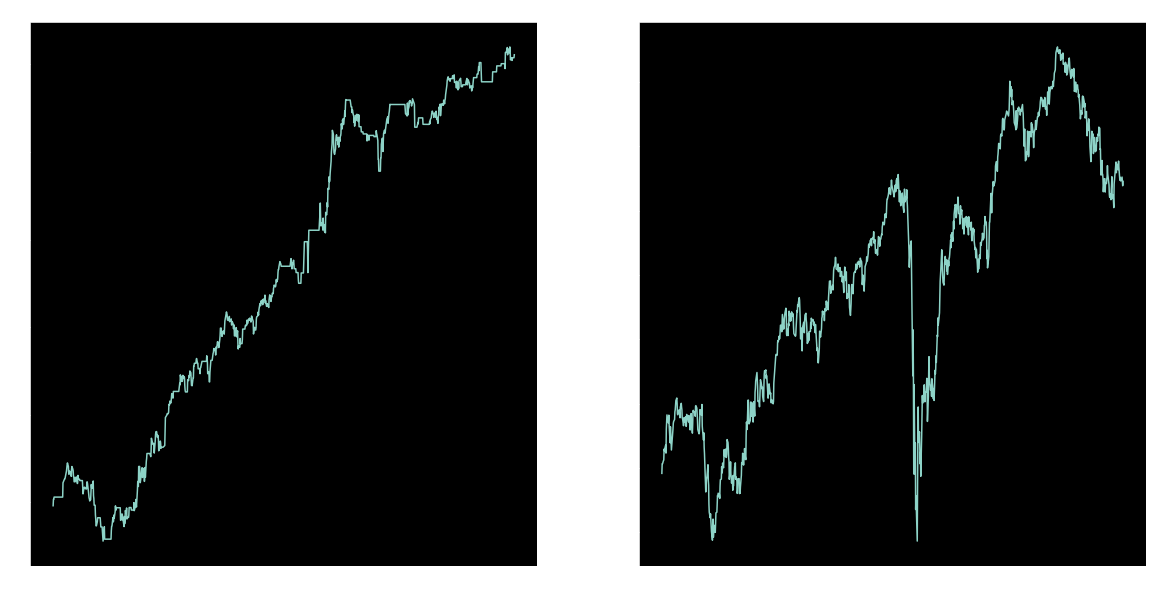

In [8]:
comparacao_ativo(df_stock,df_test) 

In [9]:
analise_resultado()

Treino
 accuracy: 0.5673885350318472               precision    recall  f1-score   support

           0       0.60      0.29      0.39      1877
           1       0.56      0.82      0.66      2048

    accuracy                           0.57      3925
   macro avg       0.58      0.56      0.53      3925
weighted avg       0.58      0.57      0.53      3925

Teste
 accuracy: 0.5295315682281059               precision    recall  f1-score   support

           0       0.50      0.40      0.44       465
           1       0.54      0.65      0.59       517

    accuracy                           0.53       982
   macro avg       0.52      0.52      0.52       982
weighted avg       0.53      0.53      0.52       982



        name      coef
4        BOP  0.171768
0        ADX  0.112219
7        MOM  0.111918
11      TRIX  0.099518
2    ARRON_D  0.092561
12  Williams  0.092485
6   MINUS_DI  0.084549
1        APO  0.064484
9        PPO  0.060779
10     Fastk  0.055689
8    PLUS_DM  0.054030
3   ARRON_UP  0.000000
5        CCI  0.000000


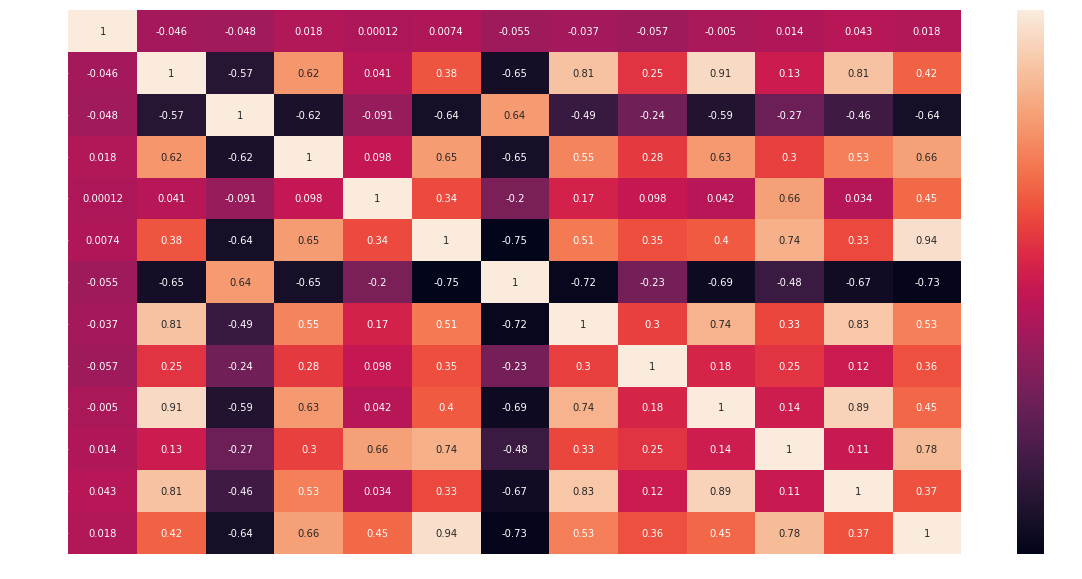

In [10]:
Analise_Feature(model,X_test)
heat_map(X_train)